In [86]:
import lzma
import json
import zipfile
import dataclasses
from pathlib import Path
from types import SimpleNamespace

import msgpack
import numpy as np
import attrs
import matplotlib.pyplot as plt
import pandas as pd

from arc25 import symmetry, tools as arc25_tools, dataset
from arc25 import serialisation

In [210]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"
model_dir = data_root / "models"
trace_dir = data_root / "traces/20251103-1415-debug-out"

In [211]:
all_known_tasks = await dataset.Dataset.from_binary(data_root / "repack/all-challenges.cbor.xz")

In [212]:
with zipfile.ZipFile(data_root/"external/arc-prize-2025.zip","r") as zfh:
    eval_sols = json.load(zfh.open("arc-agi_evaluation_solutions.json"))
    train_sols = json.load(zfh.open("arc-agi_training_solutions.json"))


In [213]:
eval_dataset = await dataset.Dataset.load_from_json(
    root=data_root/"external/arc-prize-2025.zip",
    challenges="arc-agi_evaluation_challenges.json",
    id="eval",
)
train_dataset = await dataset.Dataset.load_from_json(
    root=data_root/"external/arc-prize-2025.zip",
    challenges="arc-agi_training_challenges.json",
    id="train",
)
test_dataset = await dataset.Dataset.load_from_json(
    root=data_root/"external/arc-prize-2025.zip",
    challenges="arc-agi_test_challenges.json",
    id="test",
)
allc = train_dataset.challenges | test_dataset.challenges | eval_dataset.challenges 
main_dataset = dataset.Dataset(
    id="main",
    challenges = allc,
    subsets = dict(main=frozenset(allc)) | train_dataset.subsets | test_dataset.subsets | eval_dataset.subsets, 
)


reference_solutions = eval_sols | train_sols
reference_solutions = {k:v for k,v in reference_solutions.items() if k in main_dataset.challenges}
print(len(reference_solutions), len(main_dataset.challenges))

main_dataset = attrs.evolve(
    main_dataset,
    challenges = {
        k: attrs.evolve(v, test=[
            dataclasses.replace(ex,output=np.array(s,"i1"))
            for ex,s in zip(v.test,reference_solutions[k])
        ])
        for k,v in main_dataset.challenges.items()
    }
)

1120 1120


In [214]:
with lzma.LZMAFile(trace_dir/"training-hist.msgpack.xz","rb") as fh:
    hist = serialisation.deserialise(msgpack.loads(fh.read()))
hist = pd.DataFrame(hist)

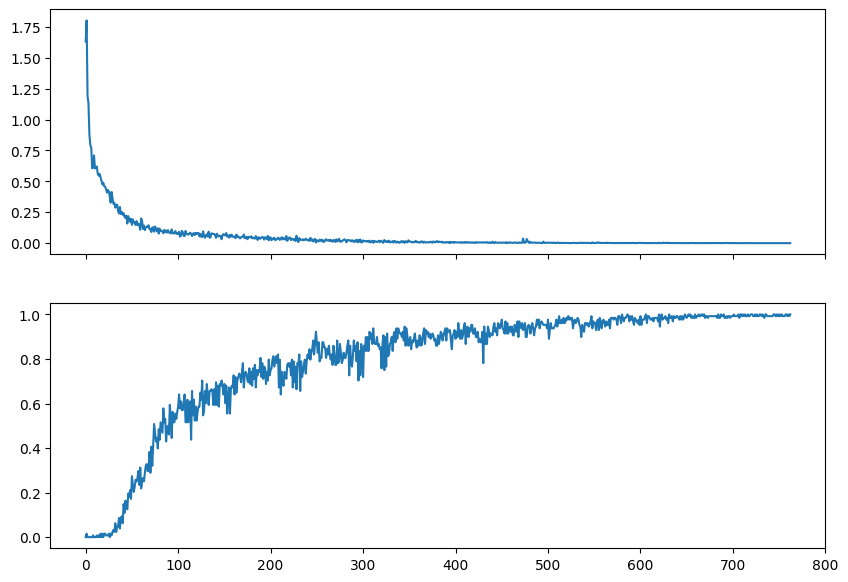

In [215]:
fig,axes = plt.subplots(2,1,figsize=(10,7),sharex=True)
for ax,v in zip(axes,[hist.pair_crossentropy, hist.pair_accuracy]):
    ax.plot(hist.index, v)

In [189]:
with open(trace_dir / "submission.json", "rt") as fh:
    submission = json.load(fh)

In [190]:
correctness = {}
for k,v in submission.items():
    all_ok = True
    for actual,expected in zip(v,main_dataset.challenges[k].test):
        ok = False
        for attempt in actual.values():
            attempt = np.array(attempt,"i1")
            if attempt.shape != expected.output.shape:
                continue
            if np.any(attempt != expected.output):
                continue
            ok = True
            break
        all_ok = all_ok and ok
    correctness[k] = all_ok
print(f"{np.mean(list(correctness.values()))*100:.1f} %")   
for k,v in all_known_tasks.subsets.items():
    seen = set(correctness) & v
    n_correct = sum([correctness[k] for k in seen])
    print(f"{k+':':24s} {n_correct/max(1,len(seen))*100:5.1f} % / {n_correct:4d} correct out of {len(seen):4d} ({len(v):4d} total)")

2.5 %
concept-arc:               0.0 % /    0 correct out of    0 ( 160 total)
arc-agi-1.evaluation:      1.0 % /    1 correct out of  101 ( 400 total)
arc-agi-1.training:        8.7 % /    8 correct out of   92 ( 400 total)
arc-agi-2.evaluation:      0.0 % /    0 correct out of  120 ( 120 total)
arc-agi-2.training:        3.8 % /    9 correct out of  240 (1000 total)
larc:                      8.7 % /    8 correct out of   92 ( 400 total)
harc.evaluation:           1.0 % /    1 correct out of  101 ( 400 total)
harc.training:             8.7 % /    8 correct out of   92 ( 400 total)
arc-agi-1:                 4.7 % /    9 correct out of  193 ( 800 total)
arc-agi-2:                 2.5 % /    9 correct out of  360 (1120 total)
harc:                      4.7 % /    9 correct out of  193 ( 800 total)
all:                       2.5 % /    9 correct out of  360 (1307 total)


In [191]:
with lzma.LZMAFile(trace_dir/"latent-pgms.msgpack.xz","rb") as fh:
    latent_pgm_data = serialisation.deserialise(msgpack.loads(fh.read()))
latent_pgms = latent_pgm_data["latent_program_embeddings"]
latent_pgms.shape

(360, 8, 8, 768)

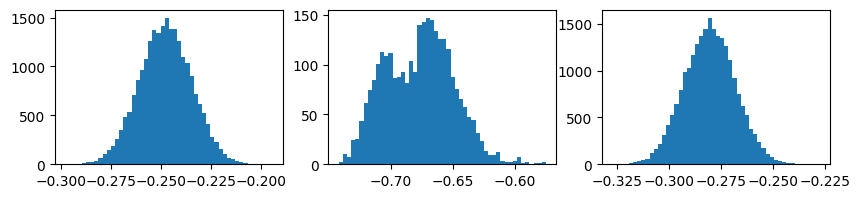

In [192]:
mlpm = latent_pgms.mean(axis=1,keepdims=True)
dlpm = latent_pgms - mlpm
fig, axes = plt.subplots(1,3,figsize=(10,2))
for ax, v in zip(axes,[latent_pgms, mlpm, dlpm]):
    _ = ax.hist(np.log10(np.linalg.norm(v,axis=-1).ravel()),bins=50)

In [193]:
with lzma.LZMAFile(trace_dir/"solutions.msgpack.xz","rb") as fh:
    tmp = serialisation.deserialise(msgpack.loads(fh.read()))
solutions = {}
for k,v in tmp.items():
    c = main_dataset.challenges[v.pop("challenge")]
    solutions[k] = SimpleNamespace(challenge=c,**v)

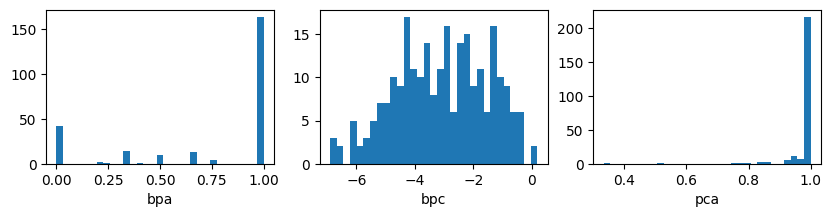

In [194]:
sstats = pd.DataFrame([dict(
    id = sol.challenge.id,
    bpa = sol.pair_accuracy.max(),
    bpc = sol.pair_crossentropy.min(),
    pca = sol.cell_accuracy.max(),
    smatch = all(
        ex.input.shape == ex.output.shape
        for ex in 
        sol.challenge.train
    ),
) for sol in solutions.values()]).set_index("id")

fig, axes = plt.subplots(1,3,figsize=(10,2))
for ax, c in zip(axes,sstats.columns):
    v = sstats.loc[sstats.smatch,c]
    if c.endswith("c"):
        v = np.log10(v)
    _ = ax.hist(v,bins=31)
    ax.set_xlabel(c)

Challenge 396d80d7 from ['all', 'arc-agi-2', 'arc-agi-2.training']
CE: 0.000, acc: 100.0 %
Challenge 3dc255db from ['all', 'arc-agi-2', 'arc-agi-2.evaluation']
CE: 0.000, acc: 100.0 %
Challenge 14b8e18c from ['all', 'arc-agi-2', 'arc-agi-2.training']
CE: 0.000, acc: 100.0 %
Challenge 1478ab18 from ['all', 'arc-agi-2', 'arc-agi-2.training']
CE: 0.000, acc: 100.0 %
Challenge faa9f03d from ['all', 'arc-agi-2', 'arc-agi-2.evaluation']
CE: 0.000, acc: 100.0 %
Challenge 37ce87bb from ['all', 'arc-agi-2', 'arc-agi-2.training']
CE: 0.000, acc: 100.0 %
Challenge dbff022c from ['all', 'arc-agi-2', 'arc-agi-2.evaluation']
CE: 0.000, acc: 100.0 %
Challenge 1818057f from ['all', 'arc-agi-2', 'arc-agi-2.evaluation']
CE: 0.000, acc: 100.0 %


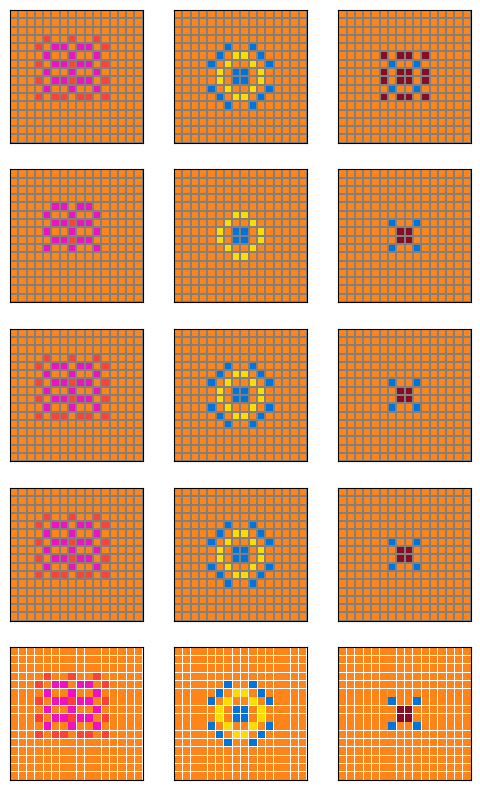

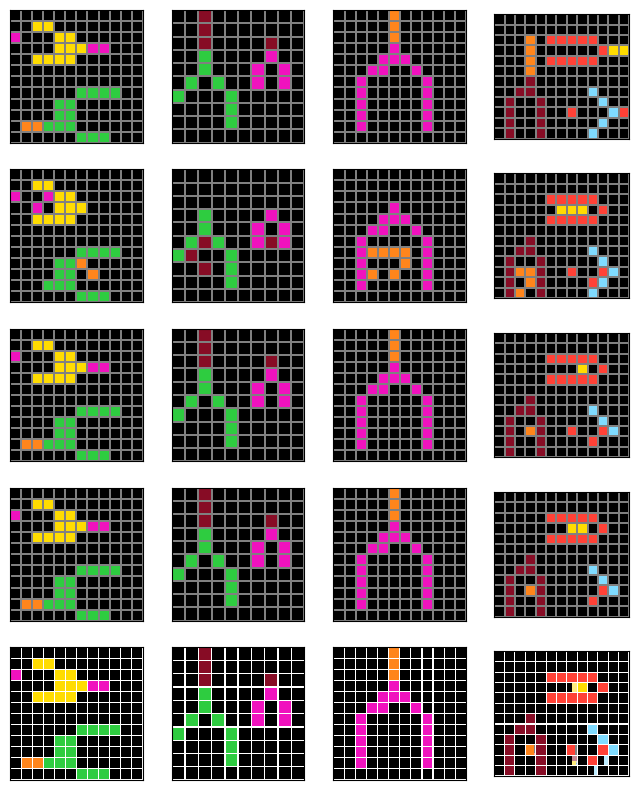

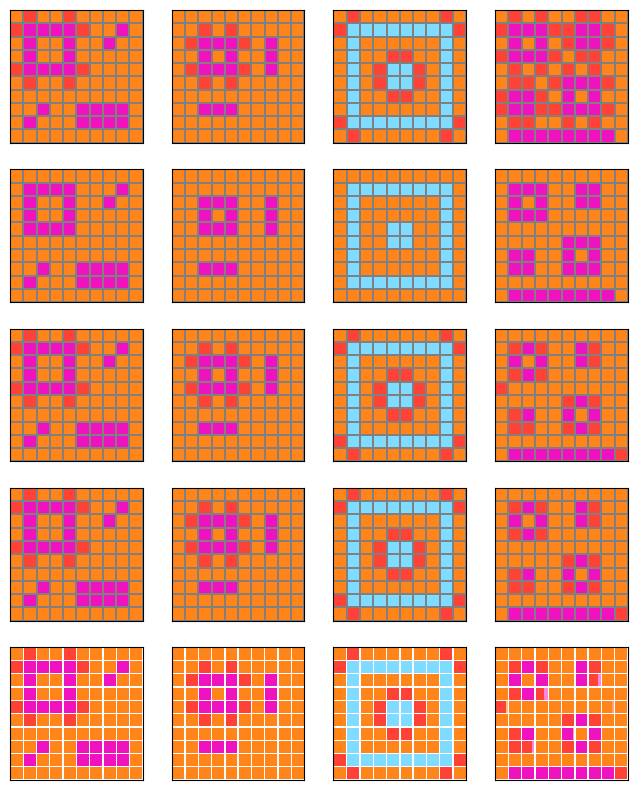

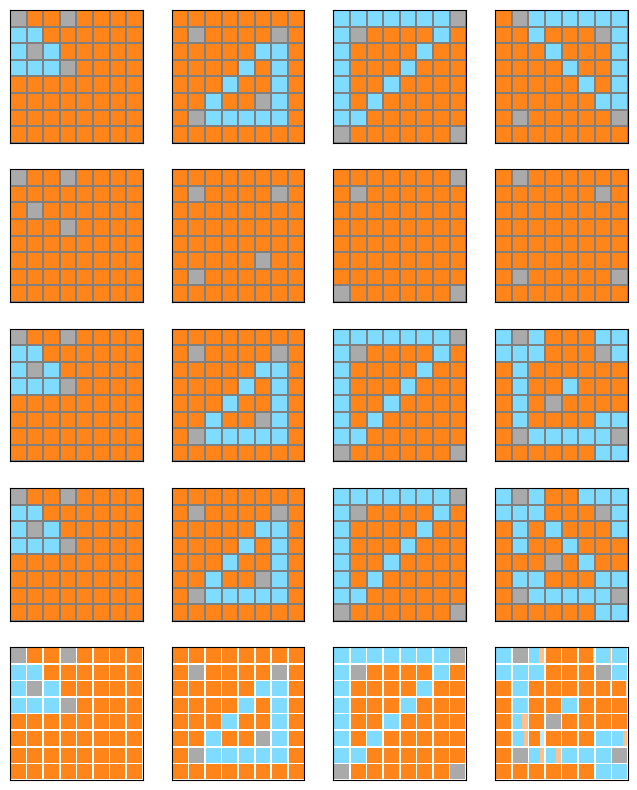

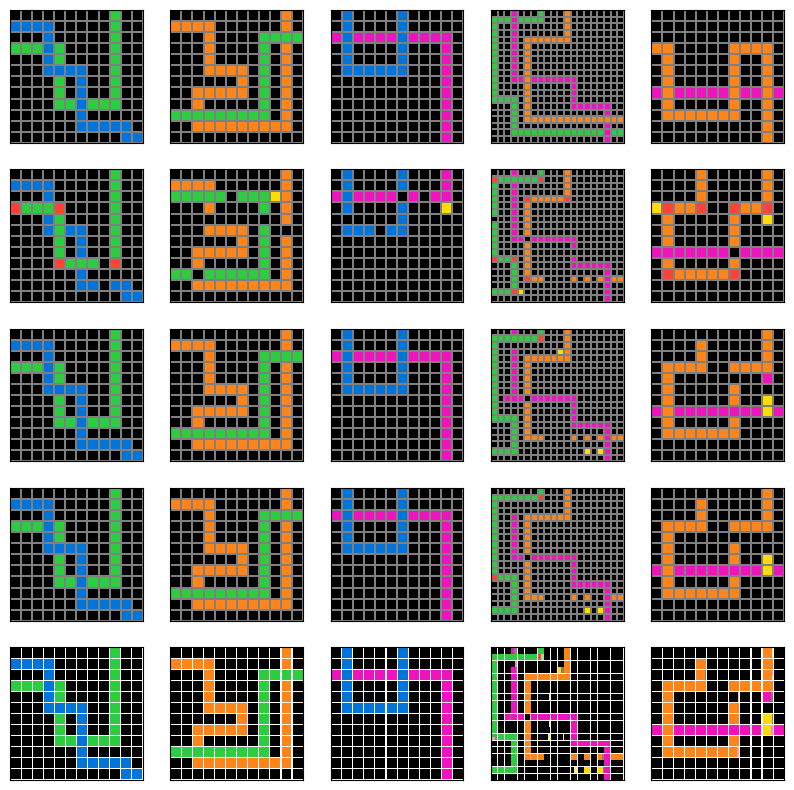

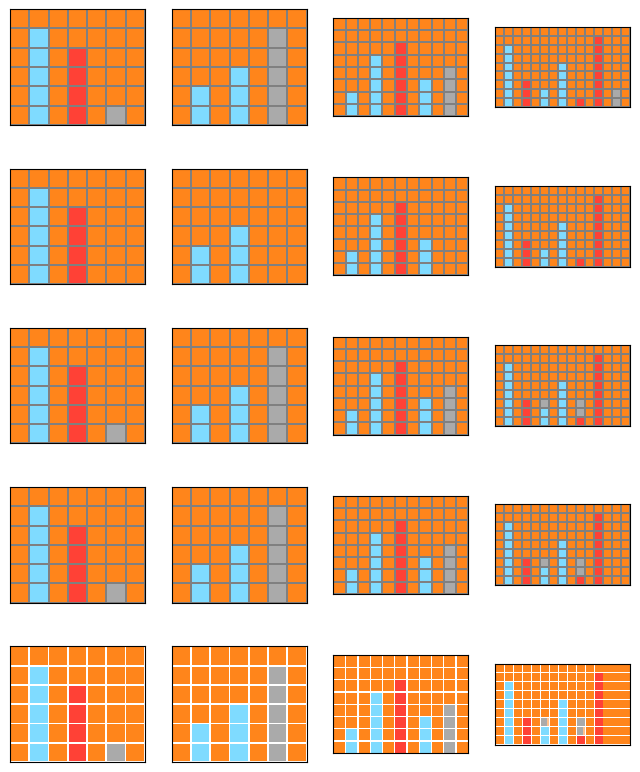

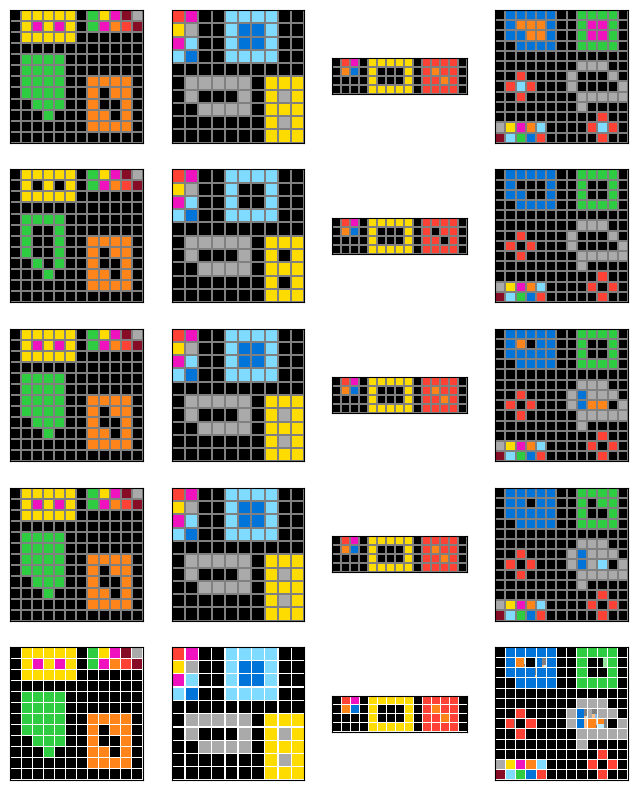

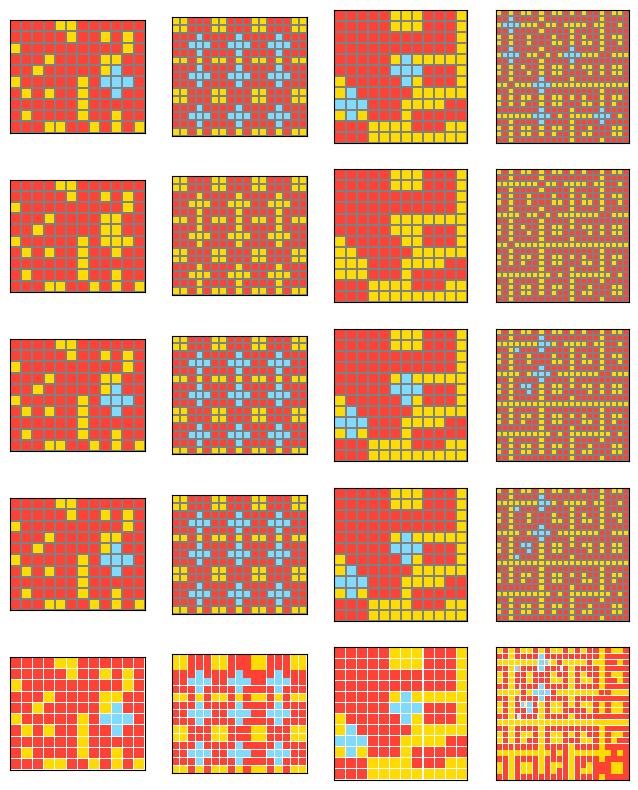

In [204]:
import scipy.special

preds = sorted(
    solutions.values(),
    key=lambda p: p.pair_crossentropy.min() if all(
        ex.input.shape == ex.output.shape
        for ex in 
        p.challenge.train
    ) and p.challenge.id not in all_known_tasks.subsets["arc-agi-1"] else np.inf
)[:8]

M = 3+2
for pred in preds:
    print(f"Challenge {pred.challenge.id} from {sorted(k for k,v in all_known_tasks.subsets.items() if pred.challenge.id in v)}")
    print(f"CE: {pred.pair_crossentropy.min():.3f}, acc: {pred.pair_accuracy.max()*100:.1f} %")
    logits = np.concatenate([pred.train_logits,pred.test_logits],axis=0)
    N = logits.shape[0]

    idx = np.argsort(pred.pair_crossentropy)
    s = 2
    fig, axes = plt.subplots(M,N,figsize=(N*s,M*s))

    voting_weight = scipy.special.softmax(-pred.pair_crossentropy)

    train_pred = []
    for ex,log in zip(pred.challenge.train,logits):
        h,w = ex.output.shape
        best_pred = np.argmax(log[0],axis=-1)
        voted_pred = (voting_weight[:,None,None,None]*scipy.special.softmax(log,axis=-1)).sum(0)
        voted_pred = np.argmax(voted_pred,axis=-1)
        train_pred.append([
            best_pred[:h,:w],
            voted_pred[:h,:w],
        ])
    
    for trip,sol,log,axe in zip(
        pred.challenge.get_empty_eval_triples(),
        train_pred+pred.final_predictions,
        logits,
        axes.T,
    ):
        ax = axe[1]
        arc25_tools.show_image(trip.input,ax=ax)
        if trip.expected is not None:
            ax = axe[0]
            arc25_tools.show_image(trip.expected,ax=ax)
            h,w = trip.expected.shape
        else:
            h,w = trip.input.shape
        if sol is not None:
            for ax,so in zip(axe[2:4],sol):
                arc25_tools.show_image(so,ax=ax)
        for ax,lg in zip(axe[4:],log[idx]):
            if True:
                arc25_tools.show_prediction(scipy.special.softmax(lg[:h,:w,:],axis=-1),ax=ax)
            else:
                arc25_tools.show_image(np.argmax(lg[:h,:w,:],axis=-1),ax=ax)